In [2]:
 import pandas as pd
import math as mt
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy import newaxis
import time
import holidays
import pickle
import warnings
warnings.filterwarnings("ignore") # may not always be the best thing to do...
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from google.colab import files
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import SelectKBest

## Link colab to your google drive
from google.colab import drive
drive.mount('/content/gdrive')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# Nilm metric
def metric_nilm(dataframe_y_true, dataframe_y_pred):
    score = 0.0
    test = dataframe_y_true[~dataframe_y_true['washing_machine'].isna()]['washing_machine']
    pred = dataframe_y_pred[~dataframe_y_true['washing_machine'].isna()]['washing_machine']
    score += mt.sqrt(sum((pred - test)**2)/len(test))*5.55
    test = dataframe_y_true[~dataframe_y_true['fridge_freezer'].isna()]['fridge_freezer']
    pred = dataframe_y_pred[~dataframe_y_true['fridge_freezer'].isna()]['fridge_freezer']
    score += mt.sqrt(sum((pred - test)**2)/len(test))*49.79
    test = dataframe_y_true[~dataframe_y_true['TV'].isna()]['TV']
    pred = dataframe_y_pred[~dataframe_y_true['TV'].isna()]['TV']
    score += mt.sqrt(sum((pred - test)**2)/len(test))*14.57
    test = dataframe_y_true[~dataframe_y_true['kettle'].isna()]['kettle']
    pred = dataframe_y_pred[~dataframe_y_true['kettle'].isna()]['kettle']
    score += mt.sqrt(sum((pred - test)**2)/len(test))*4.95
    score /= 74.86
    return score

# Custom metric for fit
def custom_metric(y_true, y_pred):
        score = mt.sqrt(sum((y_pred.get_label() - y_true) ** 2) / len(y_true)) * 49.79
        score /= 74.86
        return "nilm", score

# Create final y dataframe
def create_y_predictions(x_out_old, x_out, best_model):
  Y_out_temp = best_model.predict(x_out)
  df = pd.DataFrame(Y_out_temp)
  Y_out = pd.DataFrame(x_out_old["time_step"])
  Y_out["washing_machine"] = df.iloc[:,0]
  Y_out["fridge_freezer"] = df.iloc[:,1]
  Y_out["TV"] = df.iloc[:,2]
  Y_out["kettle"] = df.iloc[:,3]
  Y_out.index = Y_out.time_step #ligne de nao
  Y_out.to_csv('y_out.csv', header=True,index=False)
  print(Y_out)
  files.download("y_out.csv")
  return Y_out

#Modif of output
def modif_output(y_pred2_df):
  y_pred2_df['kettle'] = y_pred2_df['kettle'].apply(lambda x : 0 if x<=1 else x)
  y_pred2_df['TV'] = y_pred2_df['TV'].apply(lambda x : 0 if x<=1 else x)
  y_pred2_df['fridge_freezer'] = y_pred2_df['fridge_freezer'].apply(lambda x : 0 if x<=1 else x)
  y_pred2_df['washing_machine'] = y_pred2_df['washing_machine'].apply(lambda x : 0 if x<=1 else x)
  return y_pred2_df

In [4]:
# LSTM
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import SimpleRNN
from keras.optimizers import Adam
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Dropout
from keras.layers import Activation
from keras.metrics import mean_squared_error
from keras.callbacks import EarlyStopping
from keras.layers import InputLayer
from keras.layers import Conv1D

#!pip install -U keras-tuner
from tensorflow import keras
from tensorflow.keras import layers
#from kerastuner.tuners import RandomSearch

Using TensorFlow backend.


In [36]:
data = pd.read_csv("/content/gdrive/My Drive/ML2_final_project/data/data.csv")
data.head()

,consumption,visibility,temperature,humidity,humidex,windchill,wind,pressure,time_step,washing_machine,fridge_freezer,TV,kettle,month,day,hour,day_of_week,minute,n_days,is_holiday,is_weekend,sin_hour,cos_hour,sin_day,cos_day,sin_dow,cos_dow,peak_hours,is_breakfast,is_teatime,is_evening,avg_hourly_consumption,avg_day_of_weekly_consumption,avg_hourly_washing_machine,avg_day_of_weekly_washing_machine,avg_hourly_fridge_freezer,avg_day_of_weekly_fridge_freezer,avg_hourly_TV,avg_day_of_weekly_TV,avg_hourly_kettle,...,log_conso + 1,log_conso - 2,log_conso + 2,log_conso - 3,log_conso + 3,log_conso - 5,log_conso + 5,log_conso - 10,log_conso + 10,log_conso - 30,log_conso + 30,log_conso - 60,log_conso + 60,log_conso - 120,log_conso + 120,conso_normalised,conso / mvg_std_10,conso / mvg_std_30,conso / mvg_std_60,conso_trend,conso_anomaly,conso_low,conso_cumsum_mvg_avg_30,moving_conso_mean_3,conso - mvg_avg_3,moving_conso_mean_5,conso - mvg_avg_5,conso_cumsum_mvg_avg_3,conso_cumsum_mvg_avg_5,conso_cumsum_mvg_avg_10,conso_cumsum_mvg_avg_15,conso_cumsum_mvg_avg_20,conso_cumsum_mvg_avg_60,cumsum_diff_3,cumsum_diff_5,cumsum_diff_10,cumsum_diff_15,cumsum_diff_20,cumsum_diff_30,cumsum_diff_60
0,550.4000,23.628652,6.529775,78.36236,6.533146,3.148034,20.547753,1006.555618,2013-03-17 00:01:00,0.0,79.2000,7.0,0.0,3,17,0,6,1,15781,0,1,0.0,1.0,-0.299363,-0.954139,-0.781831,0.62349,0,0,0,0,275.842073,315.713463,16.666658,9.116859,50.053807,49.695682,9.791535,14.698118,0.002574,...,6.307370,6.310645,6.308645,6.310645,6.308766,6.310645,6.309251,6.310645,6.305180,6.310645,6.369730,6.310645,6.424058,6.310645,6.288849,473.890573,802.337957,69.811813,22.620646,520.917237,0,0,4.382633,549.433333,0.966667,549.31152,1.08848,0.966667,1.088480e+00,1.12024,3.326827,5.96637,-14.83883,0.000000,0.00000,0.0000,0.0000,0.0000,0.0000,0.0000
1,548.6000,23.628652,6.529775,78.36236,6.533146,3.148034,20.547753,1006.555618,2013-03-17 00:02:00,0.0,78.0000,7.0,0.0,3,17,0,6,2,15781,0,1,0.0,1.0,-0.299363,-0.954139,-0.781831,0.62349,0,0,0,0,275.842073,315.713463,16.666658,9.116859,50.053807,49.695682,9.791535,14.698118,0.002574,...,6.308645,6.310645,6.308766,6.310645,6.307900,6.310645,6.307135,6.310645,6.303534,6.310645,6.356108,6.310645,6.293543,6.310645,6.289509,472.090573,802.337957,69.811813,22.620646,520.827729,0,0,6.965267,549.433333,-0.833333,549.31152,-0.71152,0.133333,3.769600e-01,0.44048,4.853653,10.13274,-31.47766,-0.700000,-0.70000,-0.7000,-0.7000,-0.7000,-0.7000,-0.7000
2,549.3000,23.628652,6.529775,78.36236,6.533146,3.148034,20.547753,1006.555618,2013-03-17 00:03:00,0.0,76.9000,7.0,0.0,3,17,0,6,3,15781,0,1,0.0,1.0,-0.299363,-0.954139,-0.781831,0.62349,0,0,0,0,275.842073,315.713463,16.666658,9.116859,50.053807,49.695682,9.791535,14.698118,0.002574,...,6.308766,6.310645,6.307900,6.310645,6.309251,6.310645,6.310311,6.310645,6.303900,6.310645,6.352629,6.310645,6.293789,6.310645,6.276435,472.790573,802.337957,69.811813,22.620646,520.738222,0,0,10.247900,549.433333,-0.133333,549.31152,-0.01152,0.000000,3.654400e-01,0.46072,7.080480,14.99911,-47.41649,-0.411133,-0.06670,-0.0667,-0.0667,-0.0667,-0.0667,-0.0667
3,549.3667,23.628652,6.529775,78.36236,6.533146,3.148034,20.547753,1006.555618,2013-03-17 00:04:00,0.0,76.1111,7.0,0.0,3,17,0,6,4,15781,0,1,0.0,1.0,-0.299363,-0.954139,-0.781831,0.62349,0,0,0,0,275.842073,315.713463,16.666658,9.116859,50.053807,49.695682,9.791535,14.698118,0.002574,...,6.307900,6.307370,6.309251,6.310645,6.307135,6.310645,6.308908,6.310645,6.289344,6.310645,6.351584,6.310645,6.292495,6.310645,6.422882,472.857273,802.337957,69.811813,22.620646,520.648714,0,0,13.597233,549.088900,0.277800,549.31152,0.05518,0.277800,4.206200e-01,0.54766,9.374007,19.93218,-63.28862,0.572767,0.47580,0.4758,0.4758,0.4758,0.4758,0.4758
4,548.8909,23.628652,6.529775,78.36236,6.533146,3.148034,20.547753,1006.555618,2013-03-17 00:05:00,0.0,75.2727,7.0,0.0,3,17,0,6,5,15781,0,1,0.0,1.0,-0.299363,-0.954139,-0.781831,0.62349,0,0,0,0,275.842073,315.713463,16.666658,9.116859,50.053807,

In [0]:
#drop_index = pd.read_csv("/content/gdrive/My Drive/ML2_final_project/index_to_drop.csv")["over_70percent_missing_day"]
#data = data.drop(drop_index)

# Model 0 : 36.3 platform, 38.4 local

## 1. First fit an XGBoost on all four appliances. 

In [0]:
removed_features = ["expanding_conso_mean_10","expanding_conso_max_10", "expanding_conso_min_10",
                    "expanding_conso_median_10", "expanding_conso_std_10", "expanding_conso_mean_30", 
                    "expanding_conso_max_30", "expanding_conso_min_30", "expanding_conso_median_30",
                    "expanding_conso_std_30", "expanding_conso_mean_60", "expanding_conso_max_60",
                    "expanding_conso_min_60", "expanding_conso_median_60", "expanding_conso_std_60",]

In [0]:
selected_features =  ['consumption', 
                      'conso - 1', 'conso - 2', 'conso - 3', 'conso - 5', 'conso - 10', 'conso - 30', 'conso - 60',
                      'conso + 1', 'conso + 2', 'conso + 3', 'conso + 5', 'conso + 10', 'conso + 30', 'conso + 60',
                      'moving_conso_mean_10','moving_conso_mean_30', 'moving_conso_mean_60', 
                      'moving_conso_max_10', 'moving_conso_max_30',  'moving_conso_max_60',
                      'moving_conso_min_10', 'moving_conso_min_30','moving_conso_min_60',
                      'moving_conso_std_10', 'moving_conso_std_30','moving_conso_std_60',
                      'moving_conso_mean_15', 'moving_conso_min_15', 'moving_conso_max_15',
                      'moving_conso_mean_20', 'moving_conso_min_20', 'moving_conso_max_20',
                      "conso - mvg_avg_10",'conso - mvg_avg_30',"conso - mvg_avg_60",
                      "conso - mvg_avg_15", "conso - mvg_avg_20",
                      "conso - avg_hourly_kettle",
                      'cos_hour', 'sin_hour', 'cos_day', 'sin_day', 'cos_dow', 'sin_dow',
                      'n_days', "hour", "month", "day_of_week",
                      'temperature','pressure',
                      'peak_hours', 
                      'avg_hourly_consumption', 'avg_hourly_washing_machine','avg_hourly_fridge_freezer','avg_hourly_TV','avg_hourly_kettle',
                      'avg_day_of_weekly_consumption','avg_day_of_weekly_washing_machine','avg_day_of_weekly_fridge_freezer',
                      'avg_day_of_weekly_TV','avg_day_of_weekly_kettle',
                      #"is_winter", "is_autumn", "is_summer","is_spring" added in seasons to test their effect
                      ]

In [0]:
X = data.loc[:,selected_features]
y = data.loc[:, "washing_machine":"kettle"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=False)

In [0]:
xgb_reg = XGBRegressor(n_estimators=300, # change to 100 for better resultd
                       learning_rate = 0.1,
                       max_depth=3) # changed to 10 for better results
multi_reg = MultiOutputRegressor(xgb_reg,n_jobs=-1)

In [15]:
import time
start = time.time()
multi_reg.fit(X_train,y_train)
end = time.time()
print(end-start)

620.4137439727783


In [0]:
#Prepare y_pred to be able to use their custom metrics
y_pred = multi_reg.predict(X_test)
y_pred_df = pd.DataFrame(y_pred)
y_pred_df.columns = ["washing_machine","fridge_freezer","TV","kettle"]
y_pred_df.index = y_test.index

#Prepare y_pred_train to be able to use their custom metrics
y_pred_train = multi_reg.predict(X_train)
y_pred_train_df = pd.DataFrame(y_pred_train)
y_pred_train_df.columns = ["washing_machine","fridge_freezer","TV","kettle"]
y_pred_train_df.index = y_train.index

In [17]:
metric_nilm(y_test, y_pred_df), metric_nilm(y_train, y_pred_train_df) 

(38.751222296761405, 30.6762446116781)

In [18]:
# Fridge freezer
pred = y_pred[:,1]
test = y_test.iloc[:,1]
mt.sqrt(sum((pred - test)**2)/len(test))*49.79/74.86

27.21081663456801

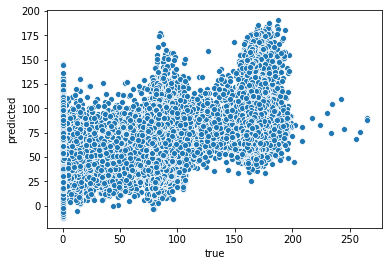

In [19]:
df = pd.DataFrame(y_pred_df["fridge_freezer"])
df["true"] = y_test["fridge_freezer"]
df.columns = ["predicted","true"]
sns.scatterplot(x= "true",y = "predicted", data=df)

In [20]:
# TV
pred = y_pred[:,2]
test = y_test.iloc[:,2]
mt.sqrt(sum((pred - test)**2)/len(test))*14.57/74.86

3.0027551966122124

In [0]:
# If you want to predict an appliance directly here and use the result
## Here I trained the boost on 95% of the data and got 2.7 score versus 4 in my TV note
#x_out = pd.read_csv("/content/gdrive/My Drive/ML2_final_project/data/x_out.csv")
#Y_out = pd.read_csv("/content/gdrive/My Drive/ML2_final_project/y_out/y_out_TV_4.csv")
#x_out = x_out[selected_features]
#x_out = x_out.fillna(method="bfill").fillna(method="ffill")
#Y_out["TV"] = multi_reg.predict(x_out)
#Y_out.to_csv("/content/gdrive/My Drive/ML2_final_project/y_out/y_out_TV_3.csv")`

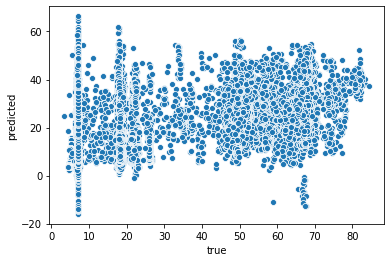

In [22]:
df = pd.DataFrame(y_pred_df["TV"])
df["true"] = y_test["TV"]
df.columns = ["predicted","true"]
sns.scatterplot(x= "true",y = "predicted", data=df)

In [23]:
# Kettle
pred = y_pred[:,3]
test = y_test.iloc[:,3]
mt.sqrt(sum((pred - test)**2)/len(test))*4.95/74.86

5.30280292837032

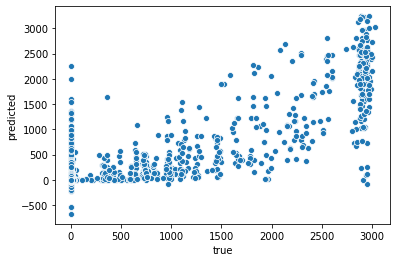

In [24]:
df = pd.DataFrame(y_pred_df["kettle"])
df["true"] = y_test["kettle"]
df.columns = ["predicted","true"]
sns.scatterplot(x= "true",y = "predicted", data=df)

In [25]:
# Washing machine
pred = y_pred[:,0]
test = y_test.iloc[:,0]
mt.sqrt(sum((pred - test)**2)/len(test))*5.55/74.86

3.23484753721087

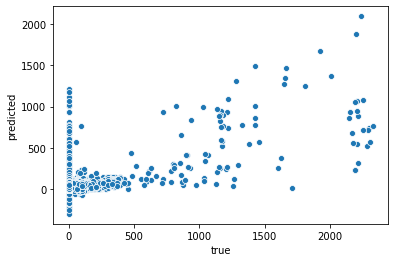

In [26]:
df = pd.DataFrame(y_pred_df["washing_machine"])
df["true"] = y_test["washing_machine"]
df.columns = ["predicted","true"]
sns.scatterplot(x= "true",y = "predicted", data=df)

In [0]:
#Y_out = pd.read_csv("/content/gdrive/My Drive/ML2_final_project/y_out/y_out_TV_4.csv")
#Y_out["washing_machine"] = pd.DataFrame(preds).iloc[:,0]
#Y_out["TV"] = pd.DataFrame(preds).iloc[:,2]

## 2. Then predict fridge on its own.

- Using 100 estimators with max depth 10 improves on 300 est, max depth 3
- Removing the expanding: fridge went from 25.87 to 25.96
- Removing avg weekly wm, TV, kettle, conso, ff: fridge went from 25.96 to 25.79
- Removing avg hourly washing machine, TV, kettle: 25.79 to 25.89 --> put it back
- Removing conso 2,3,5,10 & -2, -3, -5, -10: 25.79 to 26.51 --> put it back
- Removing conso / mvg_std 10, 30, 60: 25.79 to 26.01 --> put it back
- Add conso - rolling mean 3,5: 25.79 to 25.70
- Remove avg minute fridge std, add rolling conso 60, 30: 25.70 to ... 25.70
- Adding rolling std future and past 5, 10 25.21
- Adding rolling std future and past 3, 25.11
- Adding rolling max 5, 3: 25.13 pending -> out
- Adding conso - rolling mean  30: 25.11 to 25
- Removing conso 2, 3, 5 past and future: 25 to 25.15 because of overfit -> back in for now
- Setting the nb estimators to 300 with max depth 10 and default lr: would better the score to 24.8 with early stopping !!! 
- Tried 400 estimators, lr 0.01, max depth 10: hell of a long time, 25 to 24.9 potentially
- Adding rolling std 30, 10 : 25 to 24.88
- Removing humidex and windchill, but adding wind : 24.88 to 24.83
- Adding rolling max 10: 24.83 to 24.9 -> out
- Adding conso - mvg max 10 : 24.83 to 24.9 -> out
- Removing day of week: 24.83 to 24.93 -> put it back
- Removing cos day, sin day, day: 24.85 -> 24.82 
- Adding rolling std fridge freezer future and past 5: 24.82 to 24.82 -> out
- Removing average hourly kettle and average hourly TV: 24.82 -> 24.69!
- Removing moving min and std 30: 24.69 to 24.79 -> put it back
- Removing conso - avg hourly kettle: 24.69 to 24.8 -> put it back
- Adding winter, summer: 24.73 to 24.66! do not add spring, autumn
- Adding conso detrended 24.66 to 24.77

In [0]:
removed_features = ["expanding_conso_mean_10","expanding_conso_max_10", "expanding_conso_min_10", 
                    "expanding_conso_median_10", "expanding_conso_std_10", "expanding_conso_mean_30", 
                    "expanding_conso_max_30", "expanding_conso_min_30", "expanding_conso_median_30",
                    "expanding_conso_std_30", "expanding_conso_mean_60", "expanding_conso_max_60",
                    "expanding_conso_min_60", "expanding_conso_median_60", "expanding_conso_std_60",

                    'avg_day_of_weekly_washing_machine','avg_day_of_weekly_TV','avg_day_of_weekly_kettle',
                    'avg_day_of_weekly_consumption','avg_day_of_weekly_fridge_freezer',
                    "minutely_std_fridge_freezer",
                    'humidex', 'windchill', 
                    'cos_day', 'sin_day', "day"
                    'moving_conso_max_30', # do not remove 10, 60
                    'avg_hourly_TV','avg_hourly_kettle',
                    ]

In [0]:
features_ff = ['consumption', 
               'conso - 1',  'conso - 30', 'conso - 60', 'conso - 10','conso - 2','conso - 3', 'conso - 5', 
               'conso + 1',  'conso + 30', 'conso + 60', 'conso + 10','conso + 2', 'conso + 3', 'conso + 5',
               'moving_conso_mean_10', 'moving_conso_mean_30', 'moving_conso_mean_60', 
               'moving_conso_min_10','moving_conso_min_60','moving_conso_min_30',
               'moving_conso_std_10', 'moving_conso_std_60','moving_conso_std_30',
               'moving_conso_max_10','moving_conso_max_60',
               'moving_conso_mean_15','moving_conso_mean_20',
               'moving_conso_min_15','moving_conso_min_20',
               'moving_conso_max_15','moving_conso_max_20', 
               "moving_conso_std_15", "moving_conso_std_20", 
               "conso / mvg_std_10", "conso / mvg_std_30","conso / mvg_std_60",
               "conso - mvg_avg_10","conso - mvg_avg_30", "conso - mvg_avg_60",
               "conso - mvg_avg_15", "conso - mvg_avg_20",
               "conso_normalised",
               "conso_normalised_fridge_freezer",  "conso - avg_hourly_fridge_freezer",  "conso - avg_hourly_kettle",
               'cos_hour', 'sin_hour','sin_dow', 'cos_dow',
               "n_days","hour", "month","day_of_week",
               'temperature','pressure', 'wind',
               'peak_hours',
               'avg_hourly_consumption','avg_hourly_fridge_freezer','avg_hourly_washing_machine',
               "conso - rolling_mean_3","conso - rolling_mean_5","conso - rolling_mean_30",
               "rolling_std_future_3", "rolling_std_past_3", "rolling_std_future_5", "rolling_std_past_5", 
               "rolling_std_past_10","rolling_std_future_10", "rolling_std_past_30", "rolling_std_future_30",
               "is_winter", "is_summer",
               "conso_q_25", #"conso_q_50", 
               "conso_q_75" 
               ]

In [0]:
X2 = data.loc[:,features_ff]
y2 = data.loc[:, "washing_machine":"kettle"]
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, 
                                                        y2, 
                                                        test_size=0.20, 
                                                        shuffle=False)

In [35]:
xgb_reg = XGBRegressor(n_estimators=400,
                       max_depth = 10,
                       learning_rate=0.1)
xgb_reg.fit(X_train2,
            y_train2.iloc[:,1],
            eval_set=[(X_test2, y_test2.iloc[:,1])],
            eval_metric=custom_metric,)
            #early_stopping_rounds=10)

[17:30:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:66.1803	validation_0-nilm:44.0171
[1]	validation_0-rmse:62.2393	validation_0-nilm:41.3959
[2]	validation_0-rmse:58.7768	validation_0-nilm:39.0929
[3]	validation_0-rmse:55.8869	validation_0-nilm:37.1709
[4]	validation_0-rmse:53.4193	validation_0-nilm:35.5296
[5]	validation_0-rmse:51.3309	validation_0-nilm:34.1406
[6]	validation_0-rmse:49.5895	validation_0-nilm:32.9824
[7]	validation_0-rmse:47.9255	validation_0-nilm:31.8756
[8]	validation_0-rmse:46.5513	validation_0-nilm:30.9617
[9]	validation_0-rmse:45.3719	validation_0-nilm:30.1773
[10]	validation_0-rmse:44.4029	validation_0-nilm:29.5328
[11]	validation_0-rmse:43.5668	validation_0-nilm:28.9766
[12]	validation_0-rmse:42.6921	validation_0-nilm:28.3949
[13]	validation_0-rmse:42.118	validation_0-nilm:28.013
[14]	validation_0-rmse:41.5445	validation_0-nilm:27.6316
[15]	validation_0-rmse:41.0511

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=None, n_estimators=400,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

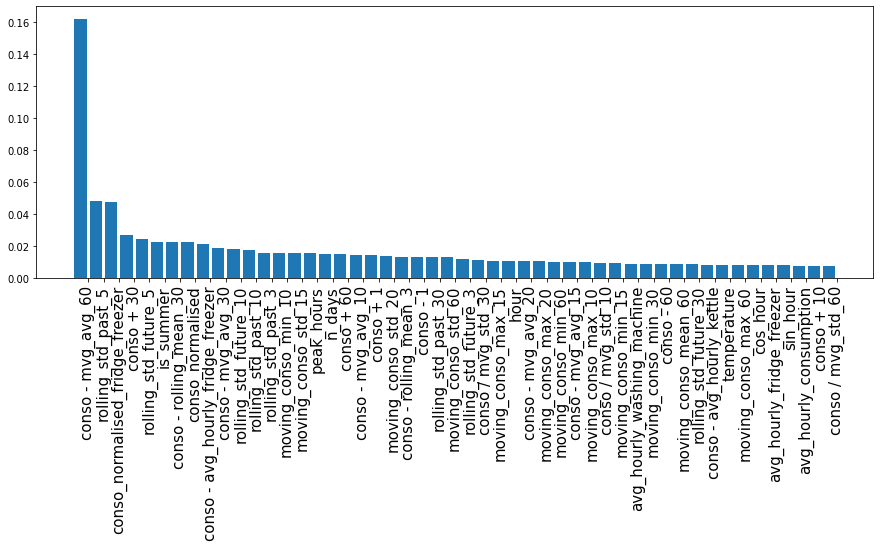

In [33]:
# Looking at the importance of each column and the prediction 
X_columns = X_train2.columns
plt.figure(figsize=(15, 5))

ordering = np.argsort(xgb_reg.feature_importances_)[::-1][:50]
importances = xgb_reg.feature_importances_[ordering]
feature_names = X_columns[ordering]
axis = np.arange(len(feature_names))
plt.bar(axis, importances)
plt.xticks(axis + 0.5, feature_names, rotation=90, fontsize=15);

In [34]:
# Metric nilm fridge freezer
pred = xgb_reg.predict(X_test2)
test = y_test2.iloc[:,1]
mt.sqrt(sum((pred - test)**2)/len(test))*49.79/74.86

25.144676804766405

In [0]:
df = pd.DataFrame(pred)
df["true"] = np.array(test)
df.columns = ["predicted","true"]
sns.set(rc={'figure.figsize':(8,8)})
sns.scatterplot(x= "true",y = "predicted", data=df)

In [0]:
xgb_reg = XGBRegressor(n_estimators=100,
                       max_depth = 10,
                       learning_rate=0.1)
xgb_reg.fit(X2,
            y2.iloc[:,1],
            )

In [0]:
x_out = pd.read_csv("/content/gdrive/My Drive/ML2_final_project/data/x_out.csv")
Y_out = pd.read_csv("/content/gdrive/My Drive/ML2_final_project/y_out/y_out_fridge_24_5.csv")

In [0]:
x_out = x_out[features_ff]

In [0]:
x_out.head()

In [0]:
Y_out["fridge_freezer"] = xgb_reg.predict(x_out)

In [0]:
Y_out = modif_output(Y_out)

In [0]:
Y_out.to_csv("/content/gdrive/My Drive/ML2_final_project/y_out/y_out_fridge_24_7.csv", index=False)

fridge freezer rather has 10-30 min bouts (https://daoyuan.li/publications/li2016profiling.pdf)

# 3. Neural network for fridge

In [0]:
## Link colab to your google drive
from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
import pandas as pd
import numpy as np
import tensorflow as tf

# LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Activation
from tensorflow.keras.metrics import mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Bidirectional
#!pip install -U keras-tuner
from tensorflow import keras
from tensorflow.keras import layers
#from kerastuner.tuners import RandomSearch
import math as mt
import keras.backend as K

In [0]:
def reshape_array(data,batch_size): 
  extra_datapoints = data.shape[0]%batch_size
  n_datapoints = data.shape[0]-extra_datapoints
  nb_steps = int(n_datapoints/batch_size)
  nb_features = 1 # for one feature only
  df = data.iloc[extra_datapoints:,] # for one feature only
  return np.array(df).reshape(batch_size,nb_steps,nb_features)

In [0]:
# Custom metric for fit
def custom_metric(y_true, y_pred):
        print(type(y_true))
        print(type(y_pred))
        score = K.sqrt(K.sum(K.cast(y_pred, dtype='float64')  - K.cast(y_true, dtype='float64') ** 2) /  K.cast(tf.size(y_true), dtype='float64') ) * 49.79
        score /= 74.86
        return(score)

In [0]:
data = pd.read_csv("/content/gdrive/My Drive/ML2_final_project/data/data_light.csv")
data.head()

In [0]:
batch_size = 10*60 # ten minutes
data_train = data.copy().loc[:,"consumption"]
data_target = data.copy().loc[:,"fridge_freezer"]
series_train = reshape_array(data_train,batch_size)
series_target = reshape_array(data_target,batch_size)
print(series_train.shape, series_target.shape)
data_train.head()

(600, 695, 1) (600, 695, 1)


0    550.4000
1    548.6000
2    549.3000
3    549.3667
4    548.8909
Name: consumption, dtype: float64

In [0]:
# Data preprocessing 
## Center by the mean of each sample
series_train_centered = (series_train - series_train.mean(axis=0))
## Standard deviation of a random subset of the data
### Generate std on random subsamples of the data
random_std = []
for i in np.arange(n_steps+1):
  random_std.append(np.std(data_train.sample(n=batch_size)))
random_std = np.array(random_std)[:,newaxis]

series_train_norm = series_train_centered / random_std

In [0]:
nb_features = 1 # consumption only
model = tf.keras.Sequential()
model.add(InputLayer(input_shape=[None,nb_features])) # length determined by appliance duration
model.add(Conv1D(filters=16,
                 kernel_size=4, 
                 strides=1, 
                 padding='same', 
                 activation='linear',))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Bidirectional(LSTM(256)))
model.add(Dropout(0.5))
model.add(Dense(128, activation="tanh"))
model.add(Dense(n_steps, activation="linear"))

In [0]:
model.summary()

In [0]:
optimizer = SGD(learning_rate=0.01, momentum=0.9, nesterov=True, clipvalue=10)
model.compile(loss=["mse"],
              optimizer=optimizer,
              metrics=[custom_metric])

In [0]:
# Defining the indexes to separate train, validation and test data
end_train_index = int(0.7*batch_size)
end_valid_index = int(0.7*batch_size)+int(0.2*batch_size)


# Defining train, validation and test data
n_steps = int(series_train.shape[1]-1) # datapoints divided by batch size, minus last step that we want to predict
nb_features = int(series_train.shape[2])

X_train, y_train = series_train_norm[:end_train_index, :n_steps], series_target[:end_train_index, :n_steps] # we want to predict something for each consumption observation
X_valid, y_valid = series_train_norm[end_train_index:end_valid_index, :n_steps], series_target[end_train_index:end_valid_index, :n_steps] 
X_test, y_test = series_train_norm[end_valid_index:, :n_steps], series_target[end_valid_index:, :n_steps]
print(X_train.shape,X_valid.shape, X_test.shape)
print(y_train.shape, y_valid.shape,y_test.shape)

In [0]:
history = model.fit(X_train, y_train, epochs=8, validation_data=(X_valid,y_valid))

In [0]:
preds = model.predict(X_test)

In [0]:
import seaborn as sns
df = pd.DataFrame(preds.flatten())
df["true"] = np.array(y_test.flatten())
df.columns = ["predicted","true"]
sns.set(rc={'figure.figsize':(8,8)})
sns.scatterplot(x= "true",y = "predicted", data=df)

In [0]:
from numpy import newaxis
np.sqrt(np.sum((preds[:,:,newaxis] - y_test)**2)/len(y_test.flatten()))*(49.79/74.86)

33.16498279714927


1. Input (length determined by appliance duration)
2. 1D conv (filter size=4, stride=1, number of filters=8, activation function=linear, border mode=valid)
3. Fully connected (N=(sequence length - 3) × 8, activation function=ReLU)
4. Fully connected (N=128; activation function=ReLU)
5. Fully connected (N=(sequence length - 3) × 8, activation function=ReLU)
6. 1D conv (filter size=4, stride=1, number of filters=1, activation function=linear, border mode=valid)

In [0]:
nb_features = 1 # consumption only
model2 = tf.keras.Sequential()
model2.add(InputLayer(input_shape=[None,nb_features])) # length determined by appliance duration
model2.add(Conv1D(filters=8,
                 kernel_size=4, 
                 strides=1, 
                 padding='valid', 
                 activation='linear',))
model2.add(Dense((batch_size-3)*8, activation="relu"))
model2.add(Dense(128, activation="relu"))
model2.add(Dense((batch_size-3)*8, activation="relu"))
model2.add(Conv1D(filters=1,
                 kernel_size=4, 
                 strides=1, 
                 padding='valid', 
                 activation='linear',))

In [0]:
model2.summary()

In [0]:
optimizer = SGD(learning_rate=0.01, momentum=0.9, nesterov=True, clipvalue=10)
model2.compile(loss=["mse"],
              optimizer=optimizer,
              metrics=[custom_metric])

In [0]:
history2 = model2.fit(X_train, y_train, epochs=8, validation_data=(X_valid,y_valid))

In [0]:
#x_out = pd.read_csv("/content/gdrive/My Drive/ML2_final_project/data/x_out_light.csv")
#batch_size = 30*60 # half hours
#x_out = x_out.copy().loc[:,"consumption"]
#series_xout = reshape_array(x_out,batch_size)

#Data preprocessing 
## Center by the mean of each sample
#series_xout_centered = (series_xout - series_xout.mean(axis=0))

## Normalise by random std on batch-sized subsamples
# Generate std on random subsamples of the data
#random_std = []
#for i in np.arange(n_steps+1):
#  random_std.append(np.std(x_out.sample(n=batch_size)))
#random_std = np.array(random_std)[:,newaxis]
#series_xout_norm = series_train_centered / random_std

#Y_out = pd.read_csv("/content/gdrive/My Drive/ML2_final_project/y_out/y_out_wm_3_full_data.csv")
#Y_out["fridge_freezer"] = pd.DataFrame(model.predict(series_xout_norm).flatten())
#Y_out = pd.to_csv("/content/gdrive/My Drive/ML2_final_project/y_out/y_out_ff_nn.csv", index=False)